### Carga de Base de datos y Librerias

In [217]:
# Cargamos todas las librerias que vamos a necesitar y abrimos la ruta al repositorio

# PARTE 1
!pip install openpyxl
!pip install matplotlib pandas
!pip install pandas pyreadstat
!pip install pandas numpy scikit-learn matplotlib
!pip install seaborn

import pandas as pd
import os # Exportamos este módulo para trabajar con carpetas
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# PARTE 2
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score, auc
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score


#Cargamos el archivo desde el directorio del GitHub
base_dir = os.getcwd() # Construye la ruta relativa al archivo CSV desde el directorio actual

# ACTIVA EL GUARDADO DE CSV DE HOGARINDIVIDUAL PARA CHEQUEAR.

In [218]:
excel_path = os.path.join(base_dir, 'usu_hogar_T124.xlsx')
hogar_eph24 = pd.read_excel(excel_path)
hogar_eph04 = pd.read_stata('Hogar_t104.dta')
datos_individual = pd.read_csv('datos_individual.csv', low_memory=False)
datos_individual_original = pd.read_csv('datos_individual.csv', low_memory=False)

### Limpieza de Datos

#### Creamos base única

In [219]:
# NOS QUEDAMOS CON LOS DATOS DEL GRAN BUENOS AIRES en las dos bases de datos

# 2004
hogar_eph04= hogar_eph04[hogar_eph04['region']=='Gran Buenos Aires']
# 2024
hogar_eph24=hogar_eph24[hogar_eph24['REGION']==1]

In [220]:
# COINCIDENCIA DE COLUMNAS

#2004
hogar_eph04.columns = hogar_eph04.columns.str.lower()
#2024
hogar_eph24.columns = hogar_eph24.columns.str.lower()


combined_df = pd.concat([hogar_eph24, hogar_eph04], ignore_index=True, sort=False)

# Identifica columnas no compartidas
columns_df1 = set(hogar_eph04.columns)
columns_df2 = set(hogar_eph24.columns)

only_in_df1 = columns_df1 - columns_df2
only_in_df2 = columns_df2 - columns_df1

print("Columnas en 2004 pero no en 2024:", only_in_df1)
print("Columnas en 2024 pero no en 2004:", only_in_df2)

columns_to_remove_2004 = only_in_df1
columns_to_remove_2024 = only_in_df2

# Elimina las columnas de 2004
hogar_eph04 = hogar_eph04.drop(columns=columns_to_remove_2004, errors='ignore')

# Elimina las columnas de 2024
hogar_eph24 = hogar_eph24.drop(columns=columns_to_remove_2024, errors='ignore')

Columnas en 2004 pero no en 2024: {'idimph'}
Columnas en 2024 pero no en 2004: {'pondih'}


In [221]:
# CREAM0S UNICO DATA FRAME
df_hogar = pd.concat([hogar_eph04, hogar_eph24], ignore_index=True, sort=False)

In [222]:
df_hogar

,codusu,nro_hogar,realizada,ano4,trimestre,region,mas_500,aglomerado,pondera,iv1,...,rdeccfr,gdeccfr,pdeccfr,adeccfr,vii1_1,vii1_2,vii2_1,vii2_2,vii2_3,vii2_4
0,125098,1.0,Sí,2004.0,1er. Trimestre,Gran Buenos Aires,S,Ciudad de Buenos Aires,1299.0,Departamento,...,06,06,,04,1.0,0.0,98.0,0.0,0.0,0.0
1,125397,1.0,Sí,2004.0,1er. Trimestre,Gran Buenos Aires,S,Ciudad de Buenos Aires,2018.0,Departamento,...,00,00,,00,1.0,0.0,98.0,0.0,0.0,0.0
2,125515,1.0,Sí,2004.0,1er. Trimestre,Gran Buenos Aires,S,Ciudad de Buenos Aires,1486.0,Departamento,...,07,07,,05,1.0,0.0,98.0,0.0,0.0,0.0
3,125558,1.0,Sí,2004.0,1er. Trimestre,Gran Buenos Aires,S,Ciudad de Buenos Aires,1674.0,Departamento,...,08,08,,06,2.0,0.0,3.0,4.0,0.0,0.0
4,125599,1.0,Sí,2004.0,1er. Trimestre,Gran Buenos Aires,S,Ciudad de Buenos Aires,1471.0,Casa,...,04,04,,02,2.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4891,TQRMNOPSSHKMROCDEIJAH00861731,1.0,1,2024.0,1,1,S,33,3772.0,1,...,10,10.0,NaN,10,1,0,96,0,0,0
4892,TQRMNOPWVHJLSSCDEIJAH00794914,1.0,1,2024.0,1,1,S,33,1862.0,1,...,2,2.0,NaN,2,4,2,98,0,0,0
4893,TQRMNOQQWHKMOQCDEIJAH00861732,1.0,1,2024.0,1,1,S,33,2639.0,1,...,12,12.0,NaN,12,2,0,98,0,0,0
4894,TQRMNOSXRHKMNMCDEIJAH00861733,1.0,1,2024.0,1,1,S,33,1497.0,2,...,10,10.0,NaN,10,1,0,98,0,0,0


In [223]:
# Hacer el merge con el parámetro indicator=True para agregar la columna '_merge'

#df_hogar = df_hogar.drop_duplicates(subset=['codusu', 'nro_hogar'])

df_completa = pd.merge(df_hogar, datos_individual, on=['codusu', 'nro_hogar'], indicator=False)
print("Columnas en df_completa:", df_completa.columns.tolist())

# Mostrar los resultados
print(f"Filas solo en df_hogar: {len(df_hogar)}")
print(f"Filas solo en datos_individual: {len(datos_individual)}")
print(f"Filas en ambos DataFrames: {len(df_completa)}")
print("Columnas en df_hogar:", df_hogar.columns.tolist())
print("Columnas en datos_individual:", datos_individual.columns.tolist())

print(f"Duplicados en df_hogar: {df_hogar[['codusu', 'nro_hogar']].duplicated().sum()}")
print(f"Duplicados en datos_individual: {datos_individual[['codusu', 'nro_hogar']].duplicated().sum()}")
# Ver las filas que no tienen coincidencia
#print("\nFilas solo en df_hogar (sin coincidencia en datos_individual):")
#print(solo_df_hogar)


# Verifica si hay valores nulos en las claves de unión
print("Valores nulos en 'codusu' de df_hogar:", df_hogar['codusu'].isnull().sum())
print("Valores nulos en 'nro_hogar' de df_hogar:", df_hogar['nro_hogar'].isnull().sum())
print("Valores nulos en 'codusu' de datos_individual:", datos_individual['codusu'].isnull().sum())
print("Valores nulos en 'nro_hogar' de datos_individual:", datos_individual['nro_hogar'].isnull().sum())


coincidencias_codusu = df_hogar['codusu'].isin(datos_individual['codusu']).sum()
coincidencias_nro_hogar = df_hogar['nro_hogar'].isin(datos_individual['nro_hogar']).sum()



print(f"Coincidencias de 'codusu': {coincidencias_codusu} de {len(df_hogar)} en df_hogar están en datos_individual")
print(f"Coincidencias de 'nro_hogar': {coincidencias_nro_hogar} de {len(df_hogar)} en df_hogar están en datos_individual")


#print("\nFilas solo en datos_individual (sin coincidencia en df_hogar):")
#print(datos_individual[['codusu', 'nro_hogar']])


completos = df_hogar[df_hogar['codusu'].isin(datos_individual['codusu']) & df_hogar['nro_hogar'].isin(datos_individual['nro_hogar'])]

print(f"Filas con coincidencia completa (tanto 'codusu' como 'nro_hogar'): {len(completos)}")


Columnas en df_completa: ['codusu', 'nro_hogar', 'realizada', 'ano4_x', 'trimestre_x', 'region_x', 'mas_500_x', 'aglomerado_x', 'pondera_x', 'iv1', 'iv1_esp', 'iv2', 'iv3', 'iv3_esp', 'iv4', 'iv5', 'iv6', 'iv7', 'iv7_esp', 'iv8', 'iv9', 'iv10', 'iv11', 'iv12_1', 'iv12_2', 'iv12_3', 'ii1', 'ii2', 'ii3', 'ii3_1', 'ii4_1', 'ii4_2', 'ii4_3', 'ii5', 'ii5_1', 'ii6', 'ii6_1', 'ii7', 'ii7_esp', 'ii8', 'ii8_esp', 'ii9', 'v1', 'v2', 'v21', 'v22', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9', 'v10', 'v11', 'v12', 'v13', 'v14', 'v15', 'v16', 'v17', 'v18', 'v19_a', 'v19_b', 'ix_tot', 'ix_men10', 'ix_mayeq10', 'itf_x', 'decifr_x', 'idecifr_x', 'rdecifr_x', 'gdecifr_x', 'pdecifr_x', 'adecifr_x', 'ipcf_x', 'deccfr_x', 'ideccfr_x', 'rdeccfr_x', 'gdeccfr_x', 'pdeccfr_x', 'adeccfr_x', 'vii1_1', 'vii1_2', 'vii2_1', 'vii2_2', 'vii2_3', 'vii2_4', 'componente', 'h15', 'ano4_y', 'trimestre_y', 'region_y', 'mas_500_y', 'aglomerado_y', 'pondera_y', 'ch03', 'ch04', 'ch06', 'ch07', 'ch08', 'ch09', 'ch10', 'ch11', 'ch

In [224]:
# Crear una lista para almacenar las columnas finales
columns_final = []

# Usar un set para evitar duplicados en los nombres base
columns_base = set()

# Iterar sobre las columnas del DataFrame
for col in df_completa.columns:
    # Quitar los sufijos '_x' y '_y' del nombre de la columna
    base_col = col.rstrip('_x').rstrip('_y')
    # Si la columna base ya fue procesada, pasar a la siguiente
    if base_col in columns_base:
        continue
    # Si no, agregar el nombre base al set de columnas procesadas
    columns_base.add(base_col)
    # Verificar si las columnas '_x' y '_y' existen en el DataFrame
    if base_col + '_x' in df_completa.columns and base_col + '_y' in df_completa.columns:
        # Conservar la columna '_x' (puedes cambiar esto a '_y' si prefieres)
        columns_final.append(base_col + '_x')
    elif base_col + '_x' in df_completa.columns:
        columns_final.append(base_col + '_x')
    elif base_col + '_y' in df_completa.columns:
        columns_final.append(base_col + '_y')
    else:
        # Si no hay sufijos, agregar la columna directamente
        columns_final.append(base_col)

# Renombrar las columnas para quitar los sufijos '_x' y '_y'
df_completa = df_completa[columns_final].rename(columns=lambda x: x.rstrip('_x').rstrip('_y'))

In [225]:
#df_completa.to_csv('C:/Users/Mili/Downloads/hogarindividual.csv', index=False)

In [226]:
print(df_completa.columns.tolist())

['codusu', 'nro_hogar', 'realizada', 'ano4', 'trimestre', 'region', 'mas_500', 'aglomerado', 'pondera', 'iv1', 'iv1_esp', 'iv2', 'iv3', 'iv3_esp', 'iv4', 'iv5', 'iv6', 'iv7', 'iv7_esp', 'iv8', 'iv9', 'iv10', 'iv11', 'iv12_1', 'iv12_2', 'iv12_3', 'ii1', 'ii2', 'ii3', 'ii3_1', 'ii4_1', 'ii4_2', 'ii4_3', 'ii5', 'ii5_1', 'ii6', 'ii6_1', 'ii7', 'ii7_esp', 'ii8', 'ii8_esp', 'ii9', 'v1', 'v2', 'v21', 'v22', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9', 'v10', 'v11', 'v12', 'v13', 'v14', 'v15', 'v16', 'v17', 'v18', 'v19_a', 'v19_b', 'ix_tot', 'ix_men10', 'ix_mayeq10', 'itf', 'decifr', 'idecifr', 'rdecifr', 'gdecifr', 'pdecifr', 'adecifr', 'ipcf', 'deccfr', 'ideccfr', 'rdeccfr', 'gdeccfr', 'pdeccfr', 'adeccfr', 'vii1_1', 'vii1_2', 'vii2_1', 'vii2_2', 'vii2_3', 'vii2_4', 'componente', 'h15', 'ch03', 'ch04', 'ch06', 'ch07', 'ch08', 'ch09', 'ch10', 'ch11', 'ch12', 'ch13', 'ch14', 'ch15', 'ch15_cod', 'ch16', 'ch16_cod', 'nivel_ed', 'estado', 'cat_ocup', 'cat_inac', 'pp02c1', 'pp02c2', 'pp02c3', 'pp02c4

In [227]:
print("Total de filas:", df_completa.shape[0])

Total de filas: 13284


In [228]:
#df_completa
#f_completa.to_csv("C:/Users/Mili/Downloads/rtrtrtrtetretert.csv", index=False)

####  Valores faltantes 

In [229]:
# Eliminar las columnas donde todas las filas son NaN
#df_completa_prueba = df_completa
print("Valores únicos antes del reemplazo:", df_completa['estado'].unique())  

for col in df_completa.columns:
    if df_completa[col].dtype in ['float64', 'int64']:  # Verificar si la columna es numérica
      if df_completa[col].apply(lambda x: isinstance(x, (int, float))).all():  
            df_completa[col] = df_completa[col].replace({'...': np.nan, 0: np.nan, -9: np.nan, 9: np.nan})

#df_completa_prueba["estado"] = df_completa_prueba["estado"].replace({'...': np.nan, 0: np.nan, -9: np.nan, 9: np.nan})

print("Valores únicos después del reemplazo:", df_completa['estado'].unique())  
      

# Asegurarnos de que los valores NaN en las columnas relevantes se eliminen
#df_completa_prueba = df_completa_prueba.dropna(subset=['estado'])
df_completa= df_completa.dropna(subset=['estado'])
print("Valores únicos finales:", df_completa['estado'].unique()) 

# Verificar los valores únicos después de dropna
#print("Valores únicos después de dropna:", df_completa_prueba['estado'].unique())  
#print("Valores únicos finales de 'estado':", df_completa_prueba['estado'].unique())

Valores únicos antes del reemplazo: [3 1 2 4 0]
Valores únicos después del reemplazo: [ 3.  1.  2.  4. nan]
Valores únicos finales: [3. 1. 2. 4.]


In [230]:
# Obtener los nombres de las columnas con valores NaN
print("CON ALGUN NAN:")
col = df_completa.columns[df_completa.isna().any()]
col_list = col.tolist()
print(col_list)

print("SIN NINGUN NAN:")
col_no_nan = df_completa.columns[df_completa.notna().all()]
col_no_nan_list = col_no_nan.tolist()
print(col_no_nan_list)

CON ALGUN NAN:
['iv1_esp', 'iv3_esp', 'iv7_esp', 'ii3_1', 'ii5_1', 'ii6_1', 'ii7_esp', 'ii8_esp', 'ix_tot', 'ix_men10', 'ix_mayeq10', 'itf', 'idecifr', 'pdecifr', 'ipcf', 'ideccfr', 'pdeccfr', 'h15', 'ch03', 'ch06', 'ch08', 'ch14', 'ch15_cod', 'ch16_cod', 'cat_inac', 'pp03c', 'pp03d', 'pp3e_tot', 'pp3f_tot', 'pp03g', 'pp03h', 'pp03i', 'pp03j', 'intensi', 'pp04a', 'pp04b_cod', 'pp04b1', 'pp04b2', 'pp04b3_mes', 'pp04b3_ano', 'pp04b3_dia', 'pp04c', 'pp04c99', 'pp04d_cod', 'pp04g', 'pp05b2_mes', 'pp05b2_ano', 'pp05b2_dia', 'pp05c_1', 'pp05c_2', 'pp05c_3', 'pp05e', 'pp05f', 'pp05h', 'pp06a', 'pp06c', 'pp06d', 'pp06e', 'pp06h', 'pp07a', 'pp07c', 'pp07d', 'pp07e', 'pp07f1', 'pp07f2', 'pp07f3', 'pp07f4', 'pp07f5', 'pp07g1', 'pp07g2', 'pp07g3', 'pp07g4', 'pp07g_59', 'pp07h', 'pp07i', 'pp07j', 'pp07k', 'pp08d1', 'pp08d4', 'pp08f1', 'pp08f2', 'pp08j1', 'pp08j2', 'pp08j3', 'pp09a', 'pp09a_esp', 'pp09b', 'pp09c', 'pp09c_esp', 'pp10a', 'pp10c', 'pp10d', 'pp10e', 'pp11a', 'pp11b_cod', 'pp11b1', 'pp11

In [231]:
#FILAS CON NAN

#df_completa = df_completa.dropna(subset=['cat_inac'])


print("Valores únicos después del reemplazo:", df_completa['cat_inac'].unique())  
#df_completa= df_completa.dropna(subset=['cat_inac'])
#print("Valores únicos finales:", df_completa['cat_inac'].unique()) 


print("Valores únicos después del reemplazo:", df_completa['itf'].unique())  
df_completa= df_completa.dropna(subset=['itf'])
print("Valores únicos finales:", df_completa['itf'].unique()) 

df_completa= df_completa.dropna(subset=['ch06'])
print("Valores únicos finales:", df_completa['ch06'].unique()) 

#df_completa = df_completa.dropna(subset=['estado'])
#COLUMNAS A ELIMINAR (vARIABLES NO CONSIDERADAS RELEVANTES)
df_completa = df_completa.drop(columns=['iv2', 'iv3', 'iv3_esp', 'iv4', 'iv6', 'iv7', 'iv7_esp', 'iv8', 'iv9', 'iv10', 'iv11']) #caracteristicas de la casa
df_completa = df_completa.drop(columns=['ii4_1', 'ii4_2', 'ii4_3', 'ii5', 'ii5_1', 'ii6', 'ii6_1', 'ii7_esp', 'ii8', 'ii8_esp', 'ii9']) #ii3 (ocupa casa para trabajar) y ii7 (regimen de tenencia del hogar) se quedan

Valores únicos después del reemplazo: [ 1. nan  4.  3.  5.  2.  7.  6.]
Valores únicos después del reemplazo: [3.6800e+02 4.4000e+02 2.1300e+03 ... 1.3007e+06 2.4800e+05 3.3900e+05]
Valores únicos finales: [3.6800e+02 4.4000e+02 2.1300e+03 ... 1.3007e+06 2.4800e+05 3.3900e+05]
Valores únicos finales: [79. 74. 54. 51. 25. 20. 55. 48. 17. 15. 77. 50. 26. 22. 18. 86. 62. 76.
 45. 41. 21. 31. 19. 52. 12. 32. 29. 64. 49. 10. 47. 43. 13.  3. 46. 78.
 60. 59. 37. 44. 30. 63. 71. 67. 87. 34. 14. 24. 28. 27. 69. 56. 33. 66.
 61.  1. 92. 65. 57. 23.  4. 40. 16. 83.  6. 38. 75. 11. 53. 73. 39. 35.
  7.  5. 36.  8. 82. 85. 72. 70. 89. 42.  2. 58. 68. 81. 80. 93. 96. 84.
 90. 94. 88. 98. 95. 91.]


In [232]:
print("Valores únicos finales:", df_completa['estado'].unique()) 


Valores únicos finales: [3. 1. 2. 4.]


In [233]:
df_completa

,codusu,nro_hogar,realizada,ano4,trimestre,region,mas_500,aglomerado,pondera,iv1,...,v5_m,v8_m,v9_m,v10_m,v11_m,v12_m,v18_m,v19_am,v21_m,t_vi
0,125098,1.0,Sí,2004.0,1er. Trimestre,Gran Buenos Aires,S,Ciudad de Buenos Aires,1299.0,Departamento,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,368.0
1,125515,1.0,Sí,2004.0,1er. Trimestre,Gran Buenos Aires,S,Ciudad de Buenos Aires,1486.0,Departamento,...,NaN,NaN,NaN,NaN,NaN,200.0,NaN,NaN,NaN,440.0
2,125558,1.0,Sí,2004.0,1er. Trimestre,Gran Buenos Aires,S,Ciudad de Buenos Aires,1674.0,Departamento,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,125558,1.0,Sí,2004.0,1er. Trimestre,Gran Buenos Aires,S,Ciudad de Buenos Aires,1674.0,Departamento,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,125558,1.0,Sí,2004.0,1er. Trimestre,Gran Buenos Aires,S,Ciudad de Buenos Aires,1674.0,Departamento,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13277,TQRMNOPWVHJLSSCDEIJAH00794914,1.0,1,2024.0,1,1,S,33,1862.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13280,TQRMNOSXRHKMNMCDEIJAH00861733,1.0,1,2024.0,1,1,S,33,1497.0,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13281,TQRMNORRQHMORPCDEIJAH00802469,1.0,1,2024.0,1,1,S,33,3120.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60000.0,200000.0
13282,TQRMNORRQHMORPCDEIJAH00802469,1.0,1,2024.0,1,1,S,33,3120.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50000.0,185000.0


In [234]:
column_types = df_completa.dtypes

# Crear una función para identificar columnas con tipos de datos mezclados
def columnas_tipos_mixtos(df):
    columnas_mixtas = []
    for columna in df.columns:
        tipos_unicos = df[columna].apply(type).unique()  # Obtener tipos únicos en la columna
        if len(tipos_unicos) > 1:  # Si hay más de un tipo de dato en la columna
            columnas_mixtas.append(columna)
    return columnas_mixtas

# Llamar a la función para encontrar las columnas con tipos de datos mezclados
columnas_mixtas = columnas_tipos_mixtos(df_completa)

# Imprimir el resultado
print("Columnas con tipos de datos mezclados:", columnas_mixtas)
print("Columnas con tipos de datos mezclados:", len(columnas_mixtas))

Columnas con tipos de datos mezclados: ['realizada', 'trimestre', 'region', 'aglomerado', 'iv1', 'iv1_esp', 'iv5', 'iv12_1', 'iv12_2', 'iv12_3', 'ii1', 'ii2', 'ii3', 'ii7', 'v1', 'v2', 'v21', 'v22', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9', 'v10', 'v11', 'v12', 'v13', 'v14', 'v15', 'v16', 'v17', 'v18', 'v19_a', 'v19_b', 'decifr', 'idecifr', 'rdecifr', 'gdecifr', 'pdecifr', 'adecifr', 'deccfr', 'ideccfr', 'rdeccfr', 'gdeccfr', 'pdeccfr', 'adeccfr', 'vii1_1', 'vii1_2', 'vii2_1', 'vii2_2', 'vii2_3', 'vii2_4', 'ch14', 'ch15_cod', 'ch16_cod', 'pp03c', 'pp03g', 'pp03h', 'pp03i', 'pp03j', 'intensi', 'pp04a', 'pp04b_cod', 'pp04b1', 'pp04c', 'pp04c99', 'pp04d_cod', 'pp04g', 'pp05c_1', 'pp05c_2', 'pp05c_3', 'pp05e', 'pp05f', 'pp05h', 'pp06a', 'pp06e', 'pp06h', 'pp07a', 'pp07c', 'pp07d', 'pp07e', 'pp07f1', 'pp07f2', 'pp07f3', 'pp07f4', 'pp07f5', 'pp07g1', 'pp07g2', 'pp07g3', 'pp07g4', 'pp07g_59', 'pp07h', 'pp07i', 'pp07j', 'pp07k', 'pp09a', 'pp09a_esp', 'pp09c_esp', 'pp10a', 'pp10c', 'pp10d', 'pp

In [235]:
#Agregar una columna llamada desocupado: vale 1 si está desocupado y 0 cc
df_completa['desocupado'] = df_completa['estado'].apply(lambda x: 1 if x in [2] else 0)

In [236]:
#df_completa.to_csv('C:/Users/Mili/Downloads/PRUEBA.csv', index=False)

####  Variables construidas

In [237]:
# PROPORCION DE PERSONAS QUE TRABAJAN EN EL HOGAR Y CANTIDAD DE PERSONAS QUE VIVEN EN EL HOGAR.

trabajadores = df_completa[df_completa['estado'] == 1]  # Filtramos por las personas que están trabajando
total_personas_hogar = df_completa.groupby(['codusu', 'nro_hogar']).size().reset_index(name='total_personas') #Agrupar por hogar y contar el TOTAL de personas en cada hogar
trabajadores_por_hogar = trabajadores.groupby(['codusu', 'nro_hogar']).size().reset_index(name='personas_trabajando') # Agrupar por hogar y contar el número de personas QUE TRABAJAN

proporcion_trabajadores = pd.merge(total_personas_hogar, trabajadores_por_hogar, on=['codusu', 'nro_hogar'], how='left') # Unimos los datos de trabajadores y el total de personas en cada hogar
proporcion_trabajadores['personas_trabajando'] = proporcion_trabajadores['personas_trabajando'].fillna(0) # Si no hay trabajadores en un hogar, rellenamos con 0
proporcion_trabajadores['proporcion_trabajando'] = proporcion_trabajadores['personas_trabajando'] / proporcion_trabajadores['total_personas'] # Calcular la proporción de trabajadores en cada hogar

# Resultado final: mostrar la proporción de trabajadores en cada hogar
proporcion_trabajadores['proporcion_trabajando'] = proporcion_trabajadores['proporcion_trabajando'].round(3)
print(proporcion_trabajadores[['codusu', 'nro_hogar', 'proporcion_trabajando']])

df_completa = pd.merge(df_completa, proporcion_trabajadores[['codusu', 'nro_hogar', 'proporcion_trabajando', 'total_personas']], on=['codusu', 'nro_hogar'], how='left')

                             codusu  nro_hogar  proporcion_trabajando
0                          125047          1.0                  0.000
1                          125098          1.0                  0.000
2                          125169          1.0                  0.333
3                          125172          2.0                  1.000
4                          125256          1.0                  0.667
...                             ...        ...                    ...
3897  TQTMNORQXHMOSQCDEIJAH00802270        1.0                  0.667
3898  TQTMNORTYHJOPMCDEIJAH00794674        1.0                  1.000
3899  TQTMNOSPRHMNROCDEIJAH00860644        1.0                  1.000
3900  TQTMNOSTRHLMKUCDEIJAH00861152        1.0                  0.500
3901  TQUMNOQSVHMOTSCDEIJAH00859221        1.0                  1.000

[3902 rows x 3 columns]


In [238]:
# Calcular la tasa parcial
# Seleccionar las columnas necesarias
df_parcial = df_completa[['v3_m', 'v5_m', 'itf']] # v3_m = INDEMNIZACION POR DESPIDO   //  v5_m = SUBSIDIO O AYUDA SOCIAL  // itf = ingreso total familiar
df_parcial[['v3_m', 'v5_m']] = df_parcial[['v3_m', 'v5_m']].fillna(0)
print(df_parcial[['v3_m', 'v5_m']].isna().sum())  # Debe devolver 0 para ambas columnas


# Reemplazar valores nulos en la columna 'itf' con 1 (porque es el denominador)
df_parcial['itf'] = df_parcial['itf'].fillna(1)

# Calcular la tasa
df_parcial['tasa'] = (df_parcial['v3_m'] + df_parcial['v5_m']) / df_parcial['itf']

# Mostrar las filas donde tasa_parcial es mayor a 0
#v = df_parcial[df_parcial['tasa'] > 0.5]  

df_completa['tasa_parcial'] = (df_parcial['tasa'] > 0.5).astype(int)  # Si La tasa de ingreso familiar DEPENDE MAS DEL 0.5 A AYUDA SOCIAL O INDEMINZACION POR DESPIDO  == 1 VA A SER MUY PROBABLE QUE ESTE DESEMPLEADO. 

#10407 EMPLEADOS CUMPLEN ESA CONDICION DE 10451 --> COINCIDE BIEN CON EMPLEADOS, LOS DESEMPLEADOS NO CUMPLEN TANTO ESTA CONDICION DE INGRESO POR SEGURO DE DESEMPLEO O PLAN SOCIAL

valores_unicos = df_completa['desocupado'].unique()
print("Valores únicos en la columna:")
print(valores_unicos)
# -----------------------------------------------------

grupo_filtrado = df_completa[(df_completa['tasa_parcial'] == 0) & (df_completa['desocupado'] == 0)]

# Imprimir las filas filtradas
print(grupo_filtrado)
cantidad_desempleados = df_completa[df_completa['desocupado'] == 1].shape[0]
print("cant de desempleados total: ",cantidad_desempleados)
cantidad_empleados = df_completa[df_completa['desocupado'] == 0].shape[0]
print("cant de empleados total: ",cantidad_empleados)

v3_m    0
v5_m    0
dtype: int64
Valores únicos en la columna:
[0 1]
                              codusu  nro_hogar realizada    ano4  \
0                           125098          1.0        Sí  2004.0   
1                           125515          1.0        Sí  2004.0   
2                           125558          1.0        Sí  2004.0   
3                           125558          1.0        Sí  2004.0   
4                           125558          1.0        Sí  2004.0   
...                              ...        ...       ...     ...   
11141  TQRMNOPWVHJLSSCDEIJAH00794914        1.0         1  2024.0   
11142  TQRMNOSXRHKMNMCDEIJAH00861733        1.0         1  2024.0   
11143  TQRMNORRQHMORPCDEIJAH00802469        1.0         1  2024.0   
11144  TQRMNORRQHMORPCDEIJAH00802469        1.0         1  2024.0   
11145  TQRMNORRQHMORPCDEIJAH00802469        1.0         1  2024.0   

            trimestre             region mas_500              aglomerado  \
0      1er. Trimestre  Gra

C:\Users\Mili\AppData\Local\Temp\ipykernel_2368\798397673.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_parcial[['v3_m', 'v5_m']] = df_parcial[['v3_m', 'v5_m']].fillna(0)
C:\Users\Mili\AppData\Local\Temp\ipykernel_2368\798397673.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_parcial['itf'] = df_parcial['itf'].fillna(1)
C:\Users\Mili\AppData\Local\Temp\ipykernel_2368\798397673.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[ro

In [239]:
# PROMEDIO EDAD HOGAR HOGAR
df_completa['prom_edad_hogar'] = df_completa.groupby(['codusu', 'nro_hogar'])['ch06'].transform('mean')


df_parcial = df_completa[['ch06', "codusu", "nro_hogar", "desocupado"]] 
df_parcial['prom_edad_hogar'] = df_parcial.groupby(['codusu', 'nro_hogar'])['ch06'].transform('mean')
# Mostrar las filas donde tasa_parcial es mayor a 0
#v = df_parcial[df_parcial['tasa'] > 0.5]  

df_filtrado = df_parcial[df_parcial['desocupado'] == 1]

df_menor_20 = df_parcial[df_parcial['prom_edad_hogar'] < 20]

# Contar cuántas filas cumplen la condición
cantidad_menor_20 = df_menor_20.shape[0]

# Imprimir la cantidad
print(f"Cantidad de personas con edad promedio menor a 20: {cantidad_menor_20}")
porcentaje_menor_20 = (cantidad_menor_20 / df_parcial.shape[0]) * 100

# Imprimir el porcentaje
print(f"Porcentaje de personas con edad promedio de hogar menor a 20: {porcentaje_menor_20:.2f}%")

# Calcular la proporción de desocupado == 1 entre las personas con edad promedio hogar menor a 20
proporcion_desocupado_1 = df_menor_20[df_menor_20['desocupado'] == 1].shape[0] / cantidad_menor_20

# Calcular la proporción de desocupado == 0 entre las personas con edad promedio menor a 20
proporcion_desocupado_0 = df_menor_20[df_menor_20['desocupado'] == 0].shape[0] / cantidad_menor_20

# Imprimir las proporciones
print(f"Proporción de desocupado con edad promedio menor a 20 (considerando solo menores a 20): {proporcion_desocupado_1}")
print(f"Proporción de ocupado con edad promedio menor a 20 (considerando solo menores a 20): {proporcion_desocupado_0}")




Cantidad de personas con edad promedio menor a 20: 1640
Porcentaje de personas con edad promedio de hogar menor a 20: 14.71%
Proporción de desocupado con edad promedio menor a 20 (considerando solo menores a 20): 0.046341463414634146
Proporción de ocupado con edad promedio menor a 20 (considerando solo menores a 20): 0.9536585365853658


C:\Users\Mili\AppData\Local\Temp\ipykernel_2368\849282110.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_parcial['prom_edad_hogar'] = df_parcial.groupby(['codusu', 'nro_hogar'])['ch06'].transform('mean')


In [240]:
hogares_menor_20 = df_parcial[df_parcial['prom_edad_hogar'] < 20]

# Contar el número de personas (componentes) por hogar
conteo_componentes = hogares_menor_20.groupby(['codusu', 'nro_hogar']).size()

# Ver cuántos hogares tienen 1, 2, 3, 5, 12 personas (componentes)
conteo_rango_componentes = conteo_componentes.value_counts()

# Imprimir el conteo de hogares con diferentes cantidades de componentes
print("Cantidad de hogares con diferentes cantidades de componentes:")
print(conteo_rango_componentes)

Cantidad de hogares con diferentes cantidades de componentes:
4     109
3      90
5      68
6      35
2      28
7      20
8       8
1       5
9       5
10      4
11      2
12      1
Name: count, dtype: int64


####  Estadísticas Descriptivas

    total_personas  media_proporcion_trabajando  cantidad_hogares
0                1                     0.505143               875
1                2                     0.456459              1045
2                3                     0.494647               812
3                4                     0.418750               600
4                5                     0.359615               312
5                6                     0.336971               138
6                7                     0.309328                61
7                8                     0.322581                31
8                9                     0.281333                15
9               10                     0.340000                 5
10              11                     0.318500                 4
11              12                     0.208000                 2
12              14                     0.429000                 1
13              15                     0.333000                 1


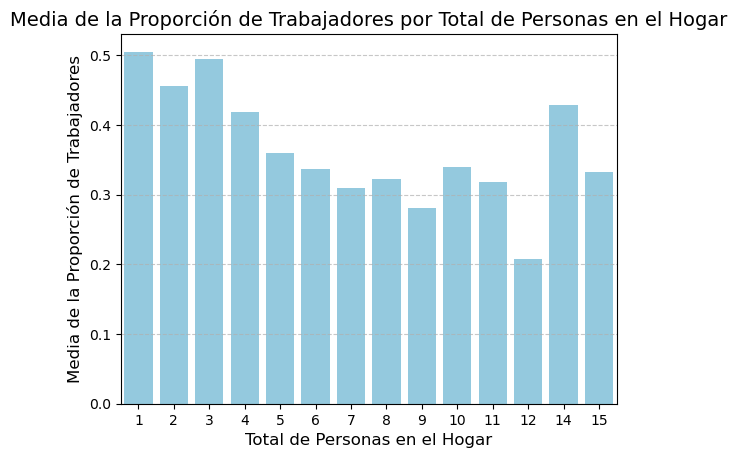

In [241]:
# Asegurarnos de que cada hogar esté representado una sola vez
hogares_unicos = df_completa[['codusu', 'nro_hogar', 'proporcion_trabajando', 'total_personas']].drop_duplicates(subset=['codusu', 'nro_hogar'])

# 0.000 865: Significa que hay 865 hogares donde la proporción de personas que trabajan es 0 (es decir, nadie trabaja en esos hogares).

# Agrupar por total_personas y calcular la media de la proporcion_trabajando
tabla_resumen = hogares_unicos.groupby('total_personas').agg(
    media_proporcion_trabajando=('proporcion_trabajando', 'mean'),
    cantidad_hogares=('codusu', 'size')
).reset_index()

# Ordenar por total_personas para mayor claridad
tabla_resumen = tabla_resumen.sort_values(by='total_personas')

# Mostrar la tabla
print(tabla_resumen)


# Crear un gráfico de barras para la media de la proporción de trabajadores
sns.barplot(data=tabla_resumen, x='total_personas', y='media_proporcion_trabajando', color='skyblue')

# Agregar etiquetas y título
plt.title('Media de la Proporción de Trabajadores por Total de Personas en el Hogar', fontsize=14)
plt.xlabel('Total de Personas en el Hogar', fontsize=12)
plt.ylabel('Media de la Proporción de Trabajadores', fontsize=12)

# Mostrar el gráfico
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

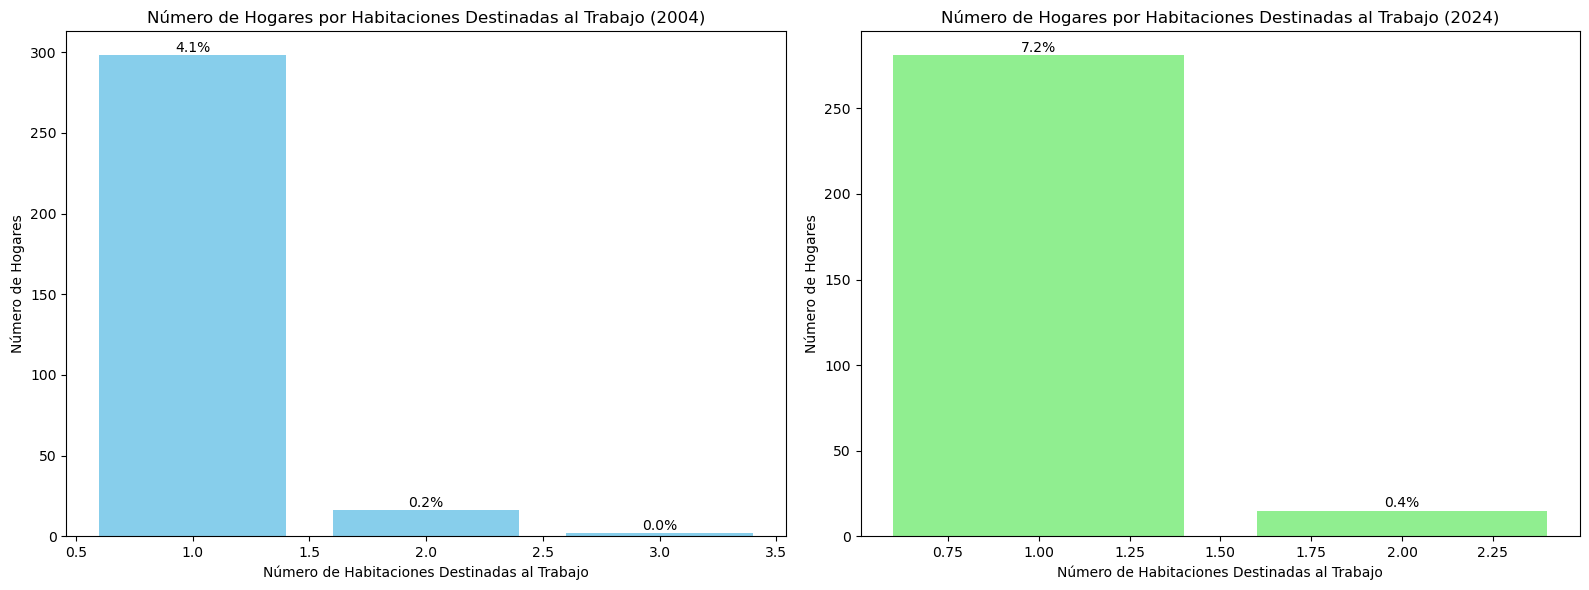

Resumen de Hogares por Habitaciones Destinadas al Trabajo (2004):
   ii3_1  cantidad_hogares  porcentaje
0    1.0               298         4.1
1    2.0                16         0.2
2    3.0                 2         0.0

Resumen de Hogares por Habitaciones Destinadas al Trabajo (2024):
   ii3_1  cantidad_hogares  porcentaje
0    1.0               281         7.2
1    2.0                15         0.4


In [250]:
# Filtrar los hogares por el año (asumiendo que tienes una columna 'ano4')
df_2004_limpio = df_completa[df_completa['ano4'] == 2004]
df_2024_limpio = df_completa[df_completa['ano4'] == 2024]
df_2004_limpio = df_2004_limpio.dropna(subset=['ii3_1'])
df_2024_limpio = df_2024_limpio.dropna(subset=['ii3_1'])

# Calcular la cantidad de hogares por número de habitaciones destinadas al trabajo en 2004
hogares_por_habitacion_trabajo_2004 = df_2004.groupby('ii3_1').size().reset_index(name='cantidad_hogares')
hogares_por_habitacion_trabajo_2004['porcentaje'] = (hogares_por_habitacion_trabajo_2004['cantidad_hogares'] / df_2004.shape[0]) * 100

# Filtrar para eliminar las filas con porcentaje 0
hogares_por_habitacion_trabajo_2004 = hogares_por_habitacion_trabajo_2004[hogares_por_habitacion_trabajo_2004['porcentaje'] > 0]

# Calcular la cantidad de hogares por número de habitaciones destinadas al trabajo en 2024
hogares_por_habitacion_trabajo_2024 = df_2024.groupby('ii3_1').size().reset_index(name='cantidad_hogares')
hogares_por_habitacion_trabajo_2024['porcentaje'] = (hogares_por_habitacion_trabajo_2024['cantidad_hogares'] / df_2024.shape[0]) * 100

# Crear gráficos para 2004 y 2024

fig, ax = plt.subplots(1, 2, figsize=(16, 6))  # Crear dos gráficos en una fila

# Gráfico para el año 2004
ax[0].bar(hogares_por_habitacion_trabajo_2004['ii3_1'], hogares_por_habitacion_trabajo_2004['cantidad_hogares'], color='skyblue')
ax[0].set_title('Número de Hogares por Habitaciones Destinadas al Trabajo (2004)')
ax[0].set_xlabel('Número de Habitaciones Destinadas al Trabajo')
ax[0].set_ylabel('Número de Hogares')

# Añadir los porcentajes sobre las barras
for i, row in hogares_por_habitacion_trabajo_2004.iterrows():
    ax[0].text(row['ii3_1'], row['cantidad_hogares'] + 2, f"{row['porcentaje']:.1f}%", ha='center')

# Gráfico para el año 2024
ax[1].bar(hogares_por_habitacion_trabajo_2024['ii3_1'], hogares_por_habitacion_trabajo_2024['cantidad_hogares'], color='lightgreen')
ax[1].set_title('Número de Hogares por Habitaciones Destinadas al Trabajo (2024)')
ax[1].set_xlabel('Número de Habitaciones Destinadas al Trabajo')
ax[1].set_ylabel('Número de Hogares')

# Añadir los porcentajes sobre las barras
for i, row in hogares_por_habitacion_trabajo_2024.iterrows():
    ax[1].text(row['ii3_1'], row['cantidad_hogares'] + 2, f"{row['porcentaje']:.1f}%", ha='center')

# Mostrar el gráfico
plt.tight_layout()
plt.show()


resumen_2004 = hogares_por_habitacion_trabajo_2004[['ii3_1', 'cantidad_hogares', 'porcentaje']]
resumen_2004['porcentaje'] = resumen_2004['porcentaje'].round(1)  # Redondear los porcentajes a un decimal
resumen_2004 = resumen_2004.sort_values(by='ii3_1')  # Ordenar por el número de habitaciones

# Mostrar el resumen del año 2004
print("Resumen de Hogares por Habitaciones Destinadas al Trabajo (2004):")
print(resumen_2004)

# Resumen para el año 2024
resumen_2024 = hogares_por_habitacion_trabajo_2024[['ii3_1', 'cantidad_hogares', 'porcentaje']]
resumen_2024['porcentaje'] = resumen_2024['porcentaje'].round(1)  # Redondear los porcentajes a un decimal
resumen_2024 = resumen_2024.sort_values(by='ii3_1')  # Ordenar por el número de habitaciones

# Mostrar el resumen del año 2024
print("\nResumen de Hogares por Habitaciones Destinadas al Trabajo (2024):")
print(resumen_2024)



In [209]:
print(df_completa['gdecifr'])

0         02
1         03
2         09
3         09
4         09
        ... 
11141    3.0
11142    7.0
11143    6.0
11144    6.0
11145    6.0
Name: gdecifr, Length: 11146, dtype: object


### Clasificación y regularización